In [11]:
import numpy as np
from scipy.linalg import expm, logm
import openqcs as op
from openqcs.tools import color_matrix, get_su2_param, su2, diagonalize
from openqcs.iterativ import get_iterative_kraus_op
import time

import matplotlib.pyplot as plt

In [23]:
def diag(rho):
    v, w = np.linalg.eigh(rho)
    
    if v[0] > v[1]:
        raise ValueError()
        
    S = np.matrix(np.diag(v))
    U = np.matrix(w, dtype=np.complex)
    
    if not np.isclose(np.linalg.norm(U.H@U - Pauli[0]), 0.0):
        raise ValueError()
    
    
    dist = np.linalg.norm(rho-U@S@U.H)
    if not np.isclose(dist, 0.0):
        raise ValueError()
        
    return S, U
        
    
    

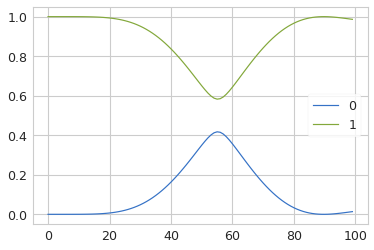

In [24]:
Pauli = [
    np.matrix(np.eye(2),        dtype=np.complex),   # identity
    np.matrix([[0,  1],[1, 0]], dtype=np.complex),   # X
    np.matrix([[0,-1j],[1j,0]], dtype=np.complex),   # Y
    np.matrix([[1,  0],[0,-1]], dtype=np.complex)    # Z
]

def H_(a,b):
    Id = Pauli[0]
    X = Pauli[1]
    Z = Pauli[3]
    
    return -a*np.kron(Z, Z) + b*(np.kron(Id,X) + np.kron(X,Id))

def T_(H, dt):
    return np.matrix(expm(-1j*H*dt))



def evo(a,b,t,dt=0.05):
    rho0 = np.matrix([[1,0],[0,0]], dtype=np.complex)
    rho_in = rho0
    n_t = int(t/dt)
    
    H = H_(a,b)
    T = T_(H,dt)
    
    data = np.zeros((n_t,2))
    
    for i in range(n_t):
        Ks = op.get_kraus_(T**(i+1))
        rho_out = op.channel_(rho0, Ks)
        
        S, U = diag(rho_out)
        
        data[i,:] = [S[0,0], S[1,1]]
        rho_in = rho_out
        
    plt.figure()
    plt.plot(data[:,0], label="0")
    plt.plot(data[:,1], label="1")
    plt.legend()
    plt.show()
    
    
        
evo(0.5, 0.5, 5.0)

In [71]:
def it_kraus(rho_in, rho_out):
    msg = {"ier": False, "err": 0.0, "phase":False}
    
    D0, U0 = diag(rho_in)
    D1, U1 = diag(rho_out)
    
    if rho_in[0,0]>1/2 and rho_out[0,0]<1/2:
        msg["phase"]=True
        msg["ier"]=True
        p = 1
        E0 = np.matrix(np.eye(2))
        E1 = np.matrix(np.eye(2))
        return p, E0, E1, msg
    
    s0 = D0[1,1]
    s1 = D1[1,1]
    
    if 1-s0 <= s1 <= s0:
        msg["ier"]=True
        
        p = (s0 - s1)/(2*s0 - 1)
        
        S0 = 1j*Pauli[2]
        S1 = Pauli[0]
        
        E0 = U1@S0@U0.H
        E1 = U1@S1@U0.H
        
        uni0 = np.linalg.norm(E0.H@E0 - Pauli[0])
        uni1 = np.linalg.norm(E1.H@E1 - Pauli[0])
        
        if not np.isclose(uni0, 0.0):
            raise ValueError()
            
        if not np.isclose(uni1, 0.0):
            raise ValueError()
        
        rho_out_proj = p*E0@rho_in@E0.H + (1-p)*E1@rho_in@E1.H
        
        msg["err"] = np.linalg.norm(rho_out_proj - rho_out)
        
        return p, E0, E1, msg
    
    elif s0 <= s1 <= 1-s0:
        msg["ier"]=True
        
        p = (s0 - s1)/(2*s0 - 1)
        
        S0 = 1j*Pauli[2]
        S1 = Pauli[0]
        
        E0 = U1@S0@U0.H
        E1 = U1@S1@U0.H
        
        uni0 = np.linalg.norm(E0.H@E0 - Pauli[0])
        uni1 = np.linalg.norm(E1.H@E1 - Pauli[0])
        
        if not np.isclose(uni0, 0.0):
            raise ValueError()
            
        if not np.isclose(uni1, 0.0):
            raise ValueError()
        
        rho_out_proj = p*E0@rho_in@E0.H + (1-p)*E1@rho_in@E1.H
        
        msg["err"] = np.linalg.norm(rho_out_proj - rho_out)
        
        return p, E0, E1, msg
    
    else:
        p = 0
        E0 = np.matrix(np.eye(2))
        E1 = np.matrix(np.eye(2))
        return p, E0, E1, msg
    

In [82]:
def iterative_evolution(T, sysbit=0):
    nbits = np.log2(T.shape[0])
    if nbits!=2:
        raise ValueError()
        

    valid = True
    n_t = 1
    n_kraus = 2**(nbits-1)
    
    data = []
    err = []
    
    rho_0 = np.matrix([[1,0],[0,0]], dtype=np.complex)
    rho_in = rho_0
    
    repair = [] 
    # indices, at which one need to do interpolation, e.g.
    # at the critical time t_crit where rho(t_crit)_{1,1} = 1/2
    
    
    while valid:
        print("#", end="", flush=True)
        Ks = op.get_kraus_(T**n_t)
        rho_out = op.channel_(rho_0, Ks)
        
        
        p, S0, S1, msg = it_kraus(rho_in, rho_out)
        
        
    
        valid = msg["ier"]
        
        if msg["phase"]:
            repair.append(n_t-1)
        
        
        if valid:
            try:
                p0 = get_su2_param(S0)
                p1 = get_su2_param(S1)
                data.append([p] + list(p0) + list(p1))
                err.append(msg["err"])
                
            except ValueError:
                repair.append(n_t-1)
                data.append([0]*7)
                err.append(msg["err"])
            n_t += 1
            
            
        rho_in = rho_out
        
    print("\nvalid time steps: ", n_t-1)
    data = np.array(data)
    err = np.array(err)
    print(repair)
    # repairing
    for idx in repair:
        if idx != 0:
            for j in range(7):
                data[idx,j] = 1/2 * (data[idx-1,j] + data[idx+1,j])
        else:
            for j in range(7):
                data[idx,j] = data[idx+1,j]
    
    return data, err, n_t-1


a = 0.5
b = 0.5
dt = 0.005

H = H_(a,b)
T = T_(H,dt)
data, err, n_t = iterative_evolution(T)

###################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################
valid time steps:  562
[0, 381]


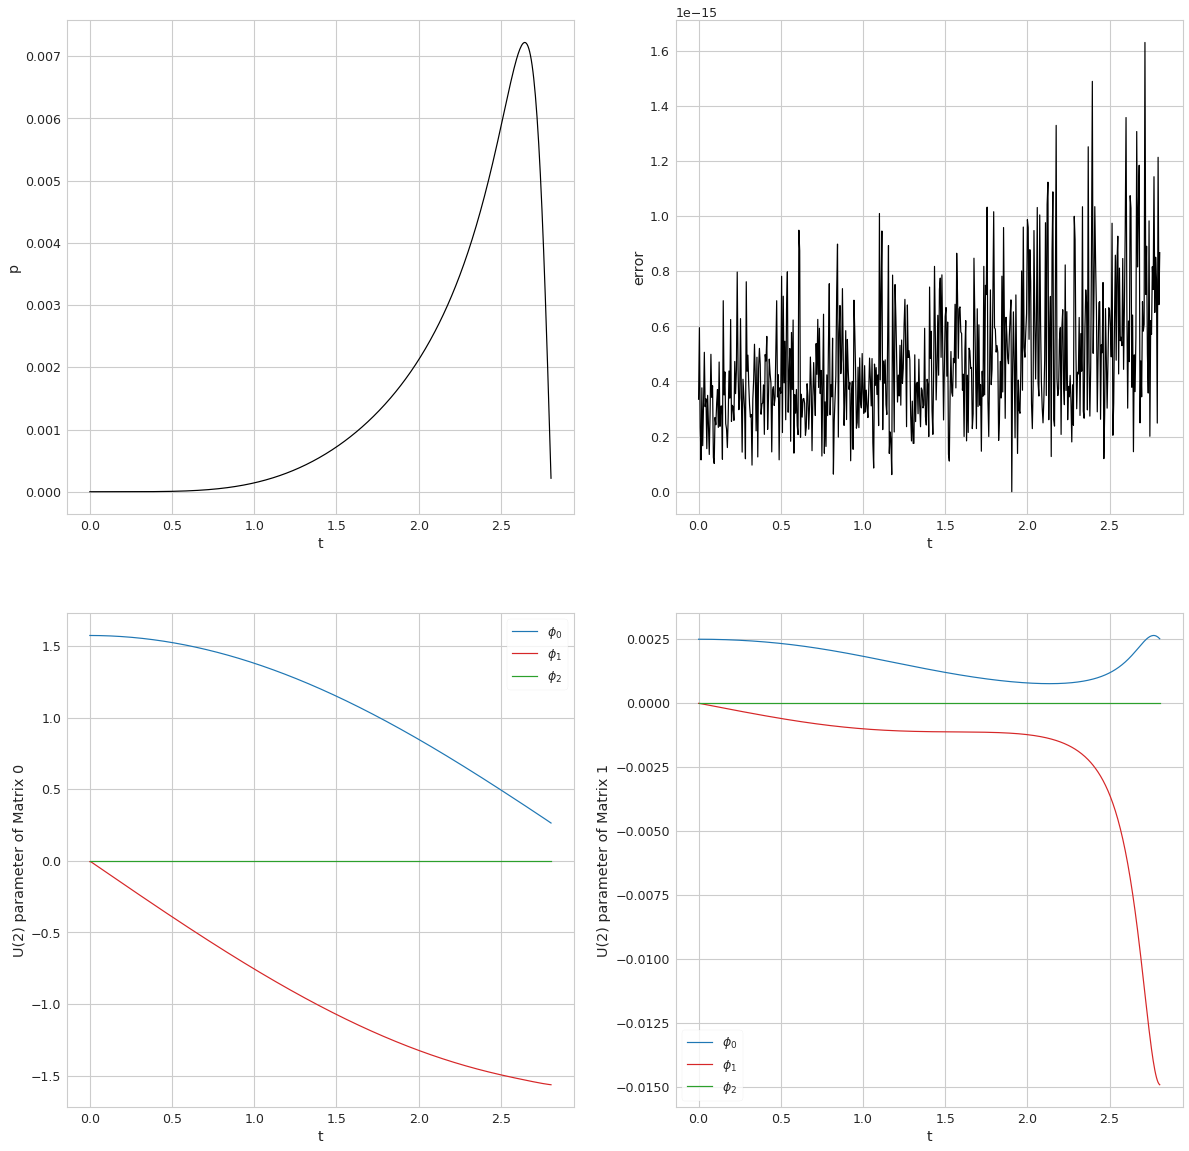

In [83]:
tdata = np.arange(n_t)*dt

labeling = [r"$\phi_0$", r"$\phi_1$", r"$\phi_2$"]
color = ["tab:blue", "tab:red", "tab:green"]

fig, axes = plt.subplots(2,2, figsize=(20,20))

axes[0,0].plot(tdata, data[:,0], color="black")
axes[0,0].set_xlabel("t")
axes[0,0].set_ylabel("p")

axes[0,1].plot(tdata, err, color="black")
axes[0,1].set_ylabel("error")
axes[0,1].set_xlabel("t")

for i in range(3):
    axes[1,0].plot(tdata, data[:,1+i], color=color[i], label=labeling[i])
    axes[1,1].plot(tdata, data[:,4+i], color=color[i], label=labeling[i])
    
for l in range(2):
    axes[1,l].set_ylabel("U(2) parameter of Matrix {}".format(l))
    axes[1,l].set_xlabel("t")
    axes[1,l].legend()
    
plt.show()
    
